In [171]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import wandb
from pathlib import Path

np.random.seed(0)  # Seed for reproducibility


def generate_signal(num_samples=100):
    """
    :param num_samples: Total number of samples in the signal
    :return: 
    """
    num_periods = np.random.randint(3, 7)  # Randomly choose how many periods to combine
    periods = np.random.randint(2, 1200, num_periods)  # Period lengths in samples
    phases = np.random.rand(num_periods) * 2 * np.pi

    # Generate random amplitudes and normalize them to sum to 1
    amplitudes = np.random.rand(num_periods)
    amplitudes /= np.sum(amplitudes)

    # Sample indices
    samples = np.arange(num_samples)

    # Generate a random continuous periodic signal
    signal = sum(amplitude * np.sin(2 * np.pi * (1 / period) * samples + phase) for amplitude, period, phase in zip(amplitudes, periods, phases))
    signal = signal / np.max(np.abs(signal))  # Normalize signal

    # Add random noise to the signal
    noise = np.random.normal(0, 0.1, signal.shape)
    signal += noise
    signal = signal / np.max(np.abs(signal))  # Normalize signal again

    return samples, signal



def reconstruct_signal_fft(signal, analysis_samples):
    # Perform FFT on the entire signal
    fft_result = torch.fft.fft(signal[:analysis_samples])
    num_samples = signal.size(0)

    # Initialize the reconstructed signal
    reconstructed_signal = torch.zeros(num_samples, dtype=torch.complex64)

    # Use all harmonics from the FFT result for reconstruction
    for index in range(analysis_samples):
        amplitude = torch.abs(fft_result[index]) / analysis_samples
        phase = torch.angle(fft_result[index])
        
        # Reconstruct using the full spectrum; no scaling factor needed
        reconstructed_signal += amplitude * torch.exp(1j * (2 * torch.pi * index * torch.arange(num_samples) / analysis_samples + phase))

    # Return the real part of the reconstructed signal
    return reconstructed_signal.real


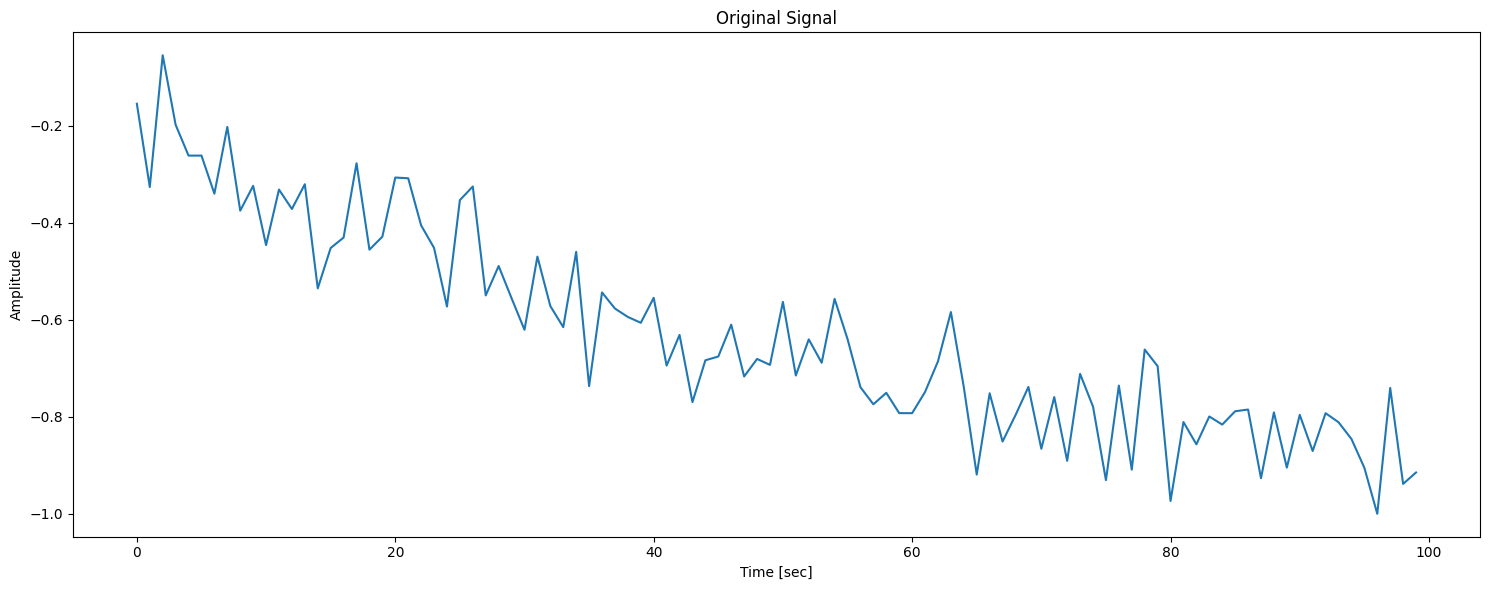

In [2]:
t, signal = generate_signal()
# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

In [7]:
class SignalDataset(Dataset):
    def __init__(self, size):
        """
        :param size: Number of samples in the dataset
        """
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal()
        # print("__getitem__")
        # Convert to PyTorch tensors
        signal = torch.tensor(signal, dtype=torch.float)
        target = torch.roll(signal, -1, dims=0)
        return signal.unsqueeze_(dim=-1), target.unsqueeze_(dim=-1)

In [32]:

class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True, num_layers=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_1 = torch.nn.Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.linear_2 = torch.nn.Linear(int(hidden_layer_size/2), output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x =  self.leaky_relu(x)
        x = self.linear_1(x)
        x = self.leaky_relu(x)
        x = self.linear_2(x)
        return x


In [38]:
# Nicer summary of model
def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = LSTMPredictor()

pram_count = count_parameters(model)
LR = 0.002
device =  torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")
print("DEVICE", device)
model.to(device)

# checkpoint_path = './checkpoints/nuaeyr5d/500_epochs_nuaeyr5d'
checkpoint_path = None

if checkpoint_path:
    checkpoint_data = checkpoint_path.split("/")[-1].split("_")
    start_epochs = int(checkpoint_data[0])
else:
    start_epochs = 0


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    800     |
| lstm.weight_hh_l0 |   160000   |
|  lstm.bias_ih_l0  |    800     |
|  lstm.bias_hh_l0  |    800     |
| lstm.weight_ih_l1 |   160000   |
| lstm.weight_hh_l1 |   160000   |
|  lstm.bias_ih_l1  |    800     |
|  lstm.bias_hh_l1  |    800     |
|  linear_1.weight  |   20000    |
|   linear_1.bias   |    100     |
|  linear_2.weight  |    100     |
|   linear_2.bias   |     1      |
+-------------------+------------+
Total Trainable Params: 504201
DEVICE cpu


In [34]:
common_kwargs={
    'project':"time-series",
    'tags': [f"lr_{LR}", f"params_{pram_count}"],
    'name':'harmonic-signal-prediction-lstm',
}
if checkpoint_path:
    wandb_id = checkpoint_data[-1]
    model.load_state_dict(torch.load(checkpoint_path))

    wandb.init(
        **common_kwargs,
        id=wandb_id,
        resume=True
    )
else:
    wandb.init(
        **common_kwargs
    )

In [39]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SignalDataset(size=1000) 
val_dataset = SignalDataset(size=1000)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 2001


for i in range(start_epochs, start_epochs + epochs + 1):
    model.train()
    train_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq.to(device))
        single_loss = loss_function(y_pred, labels.to(device))
        single_loss.backward()
        train_loss += single_loss
        optimizer.step()

    if i % 25 == 0:
        model.eval()
        val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq.to(device))
            single_loss = loss_function(y_pred, labels.to(device))
            val_loss += single_loss
        print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
        wandb.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
        if i % 100 == 0:
            Path(f"./checkpoints/{wandb.run.id}/").mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), f'./checkpoints/{wandb.run.id}/{i}_epochs_{wandb.run.id}')
        

TRAIN: epoch: 0,  loss: 3.9175126552581787
VAL: epoch: 0,  val loss: 1.217633605003357 

TRAIN: epoch: 25,  loss: 0.6162568926811218
VAL: epoch: 25,  val loss: 0.6265370845794678 

TRAIN: epoch: 50,  loss: 0.5738358497619629
VAL: epoch: 50,  val loss: 0.5825968980789185 

TRAIN: epoch: 75,  loss: 0.5353890061378479
VAL: epoch: 75,  val loss: 0.5231268405914307 

TRAIN: epoch: 100,  loss: 0.5329431295394897
VAL: epoch: 100,  val loss: 0.5260406136512756 

TRAIN: epoch: 125,  loss: 0.5344786047935486
VAL: epoch: 125,  val loss: 0.531976580619812 

TRAIN: epoch: 150,  loss: 0.5182275772094727
VAL: epoch: 150,  val loss: 0.5091279149055481 

TRAIN: epoch: 175,  loss: 0.500478982925415
VAL: epoch: 175,  val loss: 0.5151376128196716 

TRAIN: epoch: 200,  loss: 0.5040776133537292
VAL: epoch: 200,  val loss: 0.5071827173233032 

TRAIN: epoch: 225,  loss: 0.5043283104896545
VAL: epoch: 225,  val loss: 0.5057314038276672 

TRAIN: epoch: 250,  loss: 0.5362386107444763
VAL: epoch: 250,  val loss: 

In [40]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂
train loss,0.48085
val loss,0.46116


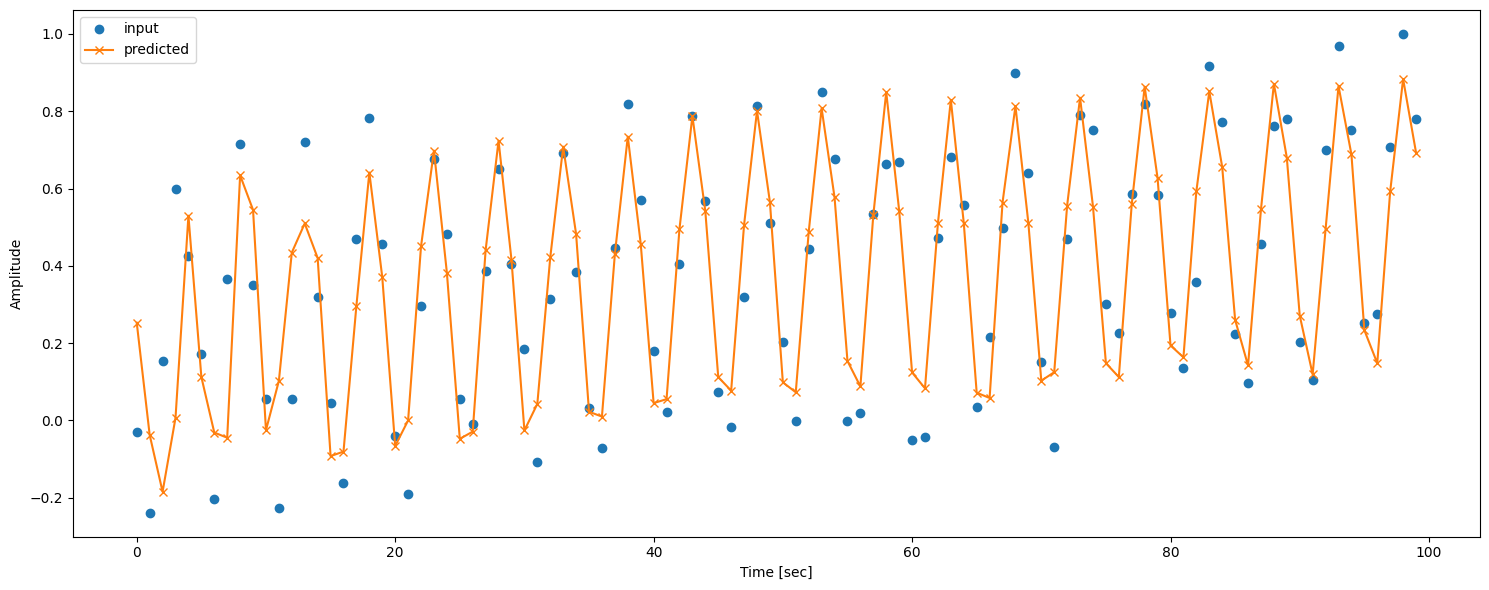

In [177]:
t, signal = generate_signal()
# N=100
# signal[N:]=np.random.uniform(size=len(signal)-N)
signal = torch.tensor(signal, dtype=torch.float)
# signal = torch.flip(signal,dims=(0,))
pred = model(signal.view(1, len(signal), 1))
predicted_signal = pred.view(len(signal)).detach()
predicted_signal = torch.roll(predicted_signal, 1, dims=0)

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, predicted_signal, '-x', label='predicted')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

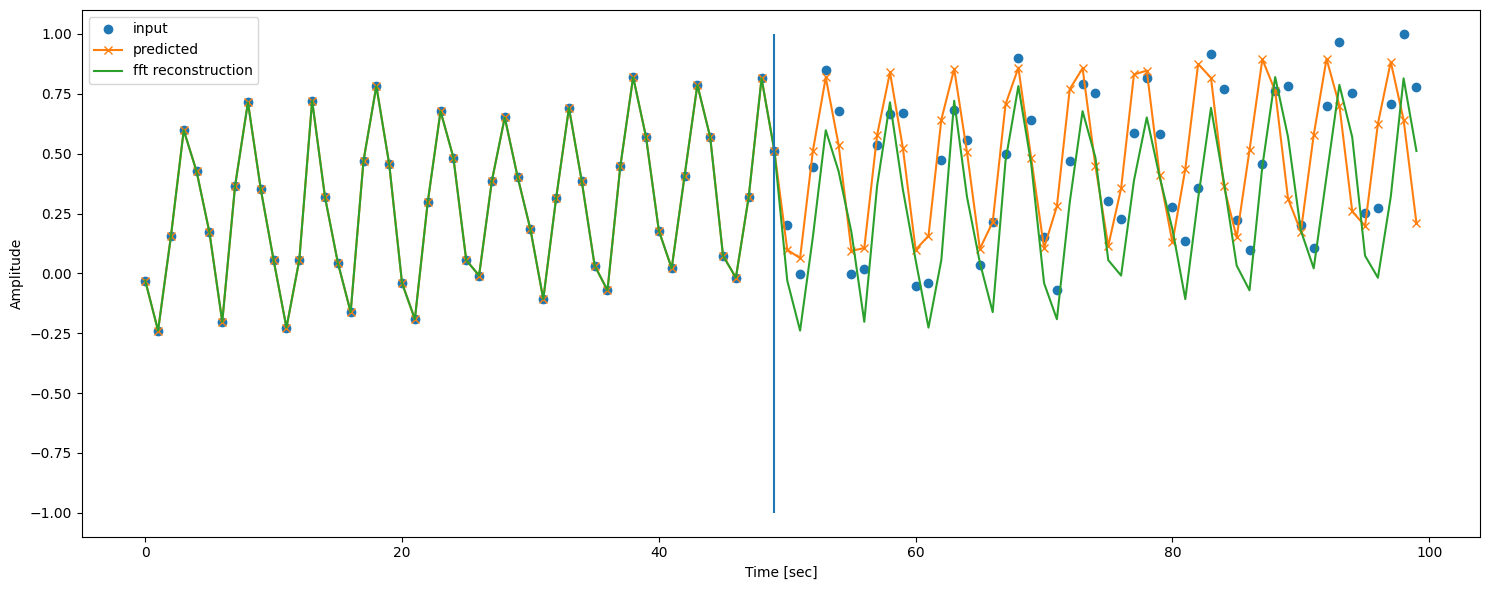

In [179]:
signal_continuation_autoreg = torch.clone(signal)
signal_continuation_autoreg[50:] = 0
for i in range(len(signal[50:])):
    pred = model(signal_continuation_autoreg.view(1, len(signal_continuation_autoreg), 1))
    pred = pred.view(len(signal_continuation_autoreg)).detach()
    signal_continuation_autoreg[50+i] = pred[50+i-1]

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, signal_continuation_autoreg, '-x', label='predicted')
plt.plot(t, reconstruct_signal_fft(signal,50), label='fft reconstruction')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.vlines(t[49], -1, 1)

plt.tight_layout()
plt.show()